In [1]:
# Import everything needed for the rest of the lecture
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# Fetch dataset from UCI ML Repository
heart_disease = fetch_ucirepo(id=45)

# Extract features and targets
X = heart_disease.data.features
y = heart_disease.data.targets

# Combine into single DataFrame
data = pd.concat([X, y], axis=1)

# Show data size
print(data.shape)

# Show first part of data
data.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [ ]:
# Note: 'data' variable is already loaded from the previous snippet
# It contains the heart disease dataset from UCI ML Repository

# Visualize data distribution
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Heart Disease Dataset - Feature Distributions', fontsize=14, fontweight='bold')

# Select a few key features to visualize
axes[0, 0].hist(data['age'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Age Distribution')

axes[0, 1].hist(data['chol'], bins=20, color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('Cholesterol')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Cholesterol Distribution')

axes[1, 0].hist(data['trestbps'], bins=20, color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('Resting Blood Pressure')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Blood Pressure Distribution')

axes[1, 1].bar(['No Disease', 'Disease'], [sum(data['num']==0), sum(data['num']>0)], 
               color=['green', 'red'], edgecolor='black')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Target Distribution')

plt.tight_layout()
plt.show()

# Plot correlations between target and all explanatory variables
# Get feature names (all columns except target)
feature_cols = [col for col in data.columns if col != 'num']
n_features = len(feature_cols)

# Create subplots
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

for idx, feature in enumerate(feature_cols):
    ax = axes[idx]

    # Violin plot without internal box/lines
    sns.violinplot(
        data=data,
        y='num',
        x=feature,
        ax=ax,
        orient='h',
        color='steelblue',
        alpha=0.4,
        inner=None  # <— removes median & quantile boxes
    )

    # Overlay raw data with vertical jitter for density visibility
    jittered_y = data['num'] + np.random.uniform(-0.1, 0.1, size=len(data))
    ax.scatter(data[feature], jittered_y, color='black', alpha=0.4, s=10)

    ax.set_ylabel('Target (num)')
    ax.set_xlabel(feature)
    ax.set_title(f'{feature} vs Target')

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

fig.suptitle('Target Variable vs All Explanatory Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [19]:
# Separate features and target
X = data.drop("num", axis=1)
y = data["num"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Training samples: 242, Test samples: 61
Number of features: 13
Target distribution: {0: 164, 1: 55, 2: 36, 3: 35, 4: 13}


Test Accuracy: 0.567
Training Accuracy: 0.679


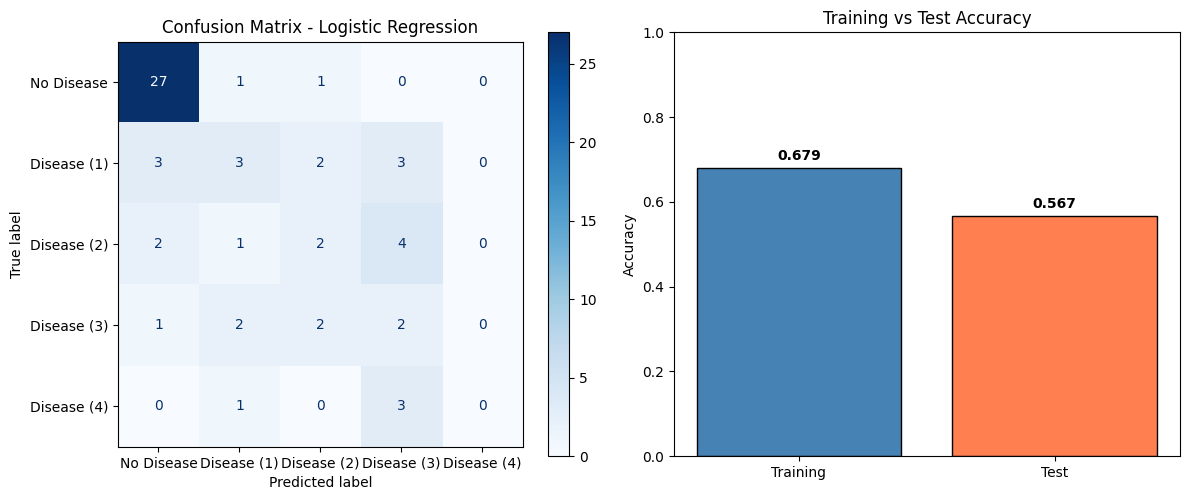

In [20]:
# Initialize and train logistic regression
model = LogisticRegression(max_iter=1000)

# Remove rows with NaNs
X_train_no_nan = X_train.dropna()
y_train_no_nan = y_train[X_train_no_nan.index]
X_test_no_nan = X_test.dropna()
y_test_no_nan = y_test[X_test_no_nan.index]

# Scale features for better convergence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_no_nan)
X_test_scaled = scaler.transform(X_test_no_nan)

model.fit(X_train_scaled, y_train_no_nan)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Evaluate accuracy
acc = accuracy_score(y_test_no_nan, y_pred)
print(f"Test Accuracy: {acc:.3f}")

# Also check training accuracy
y_train_pred = model.predict(X_train_scaled)
train_acc = accuracy_score(y_train_no_nan, y_train_pred)
print(f"Training Accuracy: {train_acc:.3f}")

# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
cm = confusion_matrix(y_test_no_nan, y_pred)
# Get unique labels from the target variable
unique_labels = sorted(y_test_no_nan.unique())
# Create display labels: 0 = No Disease, >0 = Disease
display_labels = ['No Disease' if label == 0 else f'Disease ({label})' for label in unique_labels]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix - Logistic Regression')

# Accuracy comparison
accuracies = [train_acc, acc]
labels = ['Training', 'Test']
colors = ['steelblue', 'coral']
axes[1].bar(labels, accuracies, color=colors, edgecolor='black')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([0, 1])
axes[1].set_title('Training vs Test Accuracy')
for i, v in enumerate(accuracies):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()
plt.close('all')  # Close all figures to prevent empty figure warnings